In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


In [ ]:
pd.set_option('max_columns', 200)

In [2]:
train_df = pd.read_csv("/kaggle/input/santander-customer-transaction-prediction/train.csv")
test_df = pd.read_csv("/kaggle/input/santander-customer-transaction-prediction/test.csv")

In [3]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
train_df.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [5]:
cols = train_df.columns.tolist()

In [6]:
colsobject_columns = train_df.select_dtypes(include=['object'])

In [7]:
colsobject_columns

,ID_code
0,train_0
1,train_1
2,train_2
3,train_3
4,train_4
...,...
199995,train_199995
199996,train_199996
199997,train_199997
199998,train_199998


In [8]:
train_df.set_index("ID_code", inplace = True)

In [9]:
X = train_df.drop(['target'], axis = 1)
y = train_df['target']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [11]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred_dt = model.predict(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
dt_cm = confusion_matrix(y_test, y_pred_dt)
rf_cm = confusion_matrix(y_test, y_pred_rf)

In [17]:
dt_cm
disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=train_df.target)


TypeError: float() argument must be a string or a real number, not 'ConfusionMatrixDisplay'

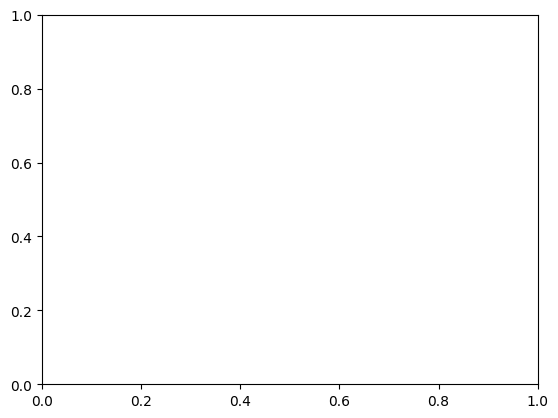

In [19]:
import matplotlib.pyplot as plt

plt.plot(disp)

In [16]:
rf_cm

array([[44880,     0],
       [ 5118,     2]])

In [ ]:
import pandas as pd
import numpy as np
from scipy.special import logit
import lightgbm as lgb

# Assuming train_df and test_df are already defined and loaded

features = [x for x in train_df.columns if x.startswith("var")]
hist_df = pd.DataFrame()

for var in features:
    var_stats = pd.concat([train_df[var], test_df[var]]).value_counts()
    hist_df[var] = pd.Series(test_df[var]).map(var_stats)
    hist_df[var] = hist_df[var] > 1

ind = hist_df.sum(axis=1) != len(features)  # Changed 200 to len(features)
var_stats = {var: pd.concat([train_df[var], test_df[ind][var]]).value_counts() for var in features}

pred = 0
for var in features:
    model = lgb.LGBMClassifier(**{
        'learning_rate': 0.05, 'max_bin': 165, 'max_depth': 5, 'min_child_samples': 150,
        'min_child_weight': 0.1, 'min_split_gain': 0.0018, 'n_estimators': 41,
        'num_leaves': 6, 'reg_alpha': 2.0, 'reg_lambda': 2.54, 'objective': 'binary', 'n_jobs': -1
    })
    
    X_train = np.hstack([train_df[var].values.reshape(-1, 1),
                         train_df[var].map(var_stats[var]).values.reshape(-1, 1)])
    y_train = train_df["target"].values
    
    model.fit(X_train, y_train)
    
    X_test = np.hstack([test_df[var].values.reshape(-1, 1),
                        test_df[var].map(var_stats[var]).values.reshape(-1, 1)])
    
    pred += logit(model.predict_proba(X_test)[:, 1])

# Create submission file
submission = pd.DataFrame({"ID_code": test_df["ID_code"], "target": pred})
submission.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

[LightGBM] [Info] Number of positive: 20098, number of negative: 179902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100490 -> initscore=-2.191792
[LightGBM] [Info] Start training from score -2.191792
[LightGBM] [Info] Number of positive: 20098, number of negative: 179902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 2
[LightGBM] [Info] 